### Captum Visual Insights for Finetuned AG News Classification  model from the BERT Pretrained Model 

This Notebook helps you to get started with the Captum Insights. In this example, we have finetuned the BERT pre-trained model using feature extraction for AG News classification which classifies the given input in one of the following classes ("world", "Sports", "Business", "Sci/Tech"). We have showcased that how we can visualize the word importances and attributions.We can visualize Captum Insights normally and making a request on torchserve as well as shown  in this notebook

In [1]:
import json
import logging
import os
import numpy as np
import torch
from transformers import BertTokenizer
from ts.torch_handler.base_handler import BaseHandler
from captum.attr import IntegratedGradients
from captum.attr import visualization
from news_classifier import BertNewsClassifier
import torch.nn.functional as F
import torch.nn as nn 

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Lets give the input data point which we want to classifiy and want to see the captum insights

In [59]:
data = {"data": ["This year business is good"]}
text = data["data"][0]
print(text)

This year business is good


Lets get all the necessary utility function and input files need to classify the input data point

In [60]:
def compute_bert_outputs(model_bert, embedding_input, attention_mask=None, head_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones(embedding_input.shape[0], embedding_input.shape[1]).to(embedding_input)

    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

    extended_attention_mask = extended_attention_mask.to(dtype=next(model_bert.parameters()).dtype) # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    if head_mask is not None:
        if head_mask.dim() == 1:
            head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            head_mask = head_mask.expand(model_bert.config.num_hidden_layers, -1, -1, -1, -1)
        elif head_mask.dim() == 2:
            head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # We can specify head_mask for each layer
        head_mask = head_mask.to(dtype=next(model_bert.parameters()).dtype) # switch to fload if need + fp16 compatibility
    else:
        head_mask = [None] * model_bert.config.num_hidden_layers

    encoder_outputs = model_bert.encoder(embedding_input,
                                         extended_attention_mask,
                                         head_mask=head_mask)
    sequence_output = encoder_outputs[0]
    pooled_output = model_bert.pooler(sequence_output)
    outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]
    return outputs 


In [61]:
model_dir =os.getcwd()
# Read model serialize/pt file
model_pt_path = os.path.join(model_dir, "state_dict.pth")
# Read model definition file
VOCAB_FILE = os.path.join(model_dir, "bert_base_uncased_vocab.txt")
if not os.path.isfile(VOCAB_FILE):
    raise RuntimeError("Missing the vocab file")

class_mapping_file = os.path.join(model_dir, "class_mapping.json")
state_dict = torch.load(model_pt_path, map_location=device)
model = BertNewsClassifier()
model.load_state_dict(state_dict)
model.to(device)
model.eval()


BertNewsClassifier(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

In [62]:
import torch.nn as nn

class AGNewsmodelWrapper(nn.Module):
    
    def __init__(self, model):
        super(AGNewsmodelWrapper, self).__init__()
        self.model = model
        
    def forward(self, embeddings):        
        outputs =compute_bert_outputs(self.model.bert_model,embeddings)
        pooled_output = outputs[1]
        output = F.relu(self.model.fc1(pooled_output))
        output = self.model.drop(output)
        output = self.model.out(output)
        print("shape of final output",output.shape)
        return output
    

In [78]:
#we first create an IntegratedGradients object, providing the model object.
ag_model_wrapper = AGNewsmodelWrapper(model)
ig_1 = IntegratedGradients(ag_model_wrapper)

In [79]:
#We get the inputs ids and embedings to pass on the model for predictions
tokenizer= BertTokenizer(VOCAB_FILE)
ag_model_wrapper.eval()
ag_model_wrapper.zero_grad()

input_ids= torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
input_embedding_test = ag_model_wrapper.model.bert_model.embeddings(input_ids)

In [65]:
input_embedding_test.shape

torch.Size([1, 7, 768])

In [80]:
#Getting the ouput and making the prediction
preds= ag_model_wrapper(input_embedding_test)
out = np.argmax(preds.cpu().detach(), axis=1)
out =(out.item())
preds

shape of final output torch.Size([1, 4])


tensor([[-4.2157, -4.3001,  3.1976,  1.3784]], grad_fn=<AddmmBackward>)

In [81]:
#Lets define the score function to get the probabilty for predicted class
def score_func(o):
    output = F.softmax(o, dim=1)
    pre_pro= np.max(output.detach().numpy())
    return pre_pro

score_func(preds)

0.85961217

In [82]:
#We can create a reference baselines for pass in to the IG object.
text_ref ="PAD PAD PAD PAD PAD"
input_id_ref= torch.tensor([tokenizer.encode(text_ref, add_special_tokens=True)])
input_embedding_ref = ag_model_wrapper.model.bert_model.embeddings(input_id_ref)
input_embedding_ref.shape


torch.Size([1, 7, 768])

In [83]:
#Lets calculate the IG attributions attributing towards for target class 1 
attributions, delta = ig_1.attribute(input_embedding_test, n_steps=500, return_convergence_delta=True, target=1,baselines =input_embedding_ref)

shape of final output torch.Size([500, 4])
shape of final output torch.Size([1, 4])
shape of final output torch.Size([1, 4])


In [84]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].numpy().tolist())    
tokens

['[CLS]', 'this', 'year', 'business', 'is', 'good', '[SEP]']

Lets visulize the captum insights below

In [91]:
vis_data_records_base=[]

In [86]:
def add_attributions_to_visualizer(attributions, tokens, pred_prob, pred_class, true_class,attr_class, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.detach().numpy()
    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred_prob,
                            pred_class,
                            true_class,
                            attr_class,
                            attributions.sum(),       
                            tokens,
                            delta))


In [87]:
add_attributions_to_visualizer(attributions, tokens, score_func(preds), out, 2,1, delta, vis_data_records_base)

In [88]:
vis_data_records_base

In [89]:
visualization.visualize_text(vis_data_records_base)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.86),1,-0.34,[CLS] this year business is good [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.86),1,-0.34,[CLS] this year business is good [SEP]


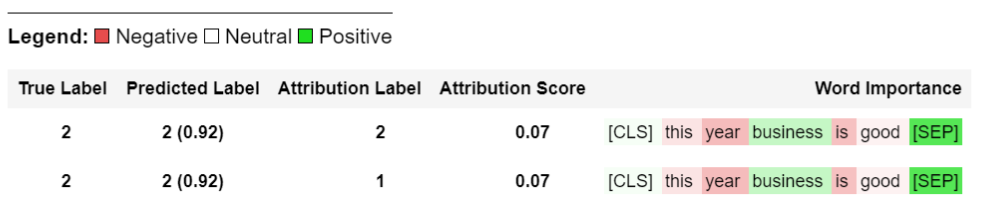

In [6]:
import IPython.display
IPython.display.Image(filename="AGNews_Captum_Insights_0.png")


### Making explain request using torchserve  and visulize the captum insights

Create the mar file for the AG News classification model and place the artefacts from where you can serve the model. 


In [92]:
!mlflow deployments create -t torchserve -m state_dict.pth --name news_classification_test -C "VERSION=1.0" -C "MODEL_FILE=news_classifier.py" -C "HANDLER=news_classifier_handler.py" -C "EXTRA_FILES=class_mapping.json,bert_base_uncased_vocab.txt,wrapper.py"


None deployment news_classification_test/1.0 is created


In [93]:
!mlflow deployments explain --name news_classification_test --target torchserve --input-path input.json --output-path output.json

Lets read the output json created by the above step for visulization purpose

In [94]:
import json
input_file=open('./output.json', 'r')
input_json = json.load(input_file)
input_json =json.loads(input_json)

In [95]:
print(input_json)
print(type(input_json))


{'words': ['[CLS]', 'this', 'year', 'business', 'is', 'good', '[SEP]'], 'importances': [0.08991567404246674, -0.14802681270486315, -0.41718128976163793, 0.2256927237290009, -0.3142787171026753, -0.10879051751774257, 0.796504432809415], 'delta': 1.3522652356019162}
<class 'dict'>


In [96]:
attributions = input_json['importances']
words = input_json['words']
delta = input_json['delta']

print("len of words and importances",len(attributions),len(words))

len of words and importances 7 7


In [97]:
attributions = torch.tensor(attributions)
pred_prob = score_func(preds)
pred_class = out
true_class = 2
attr_class =1

In [98]:
vis_data_records =[]

In [54]:
vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred_prob,
                            pred_class,
                            true_class,
                            attr_class,
                            attributions.sum(),       
                            tokens,
                            delta))


In [55]:
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.86),1,0.12,[CLS] this year business is good [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.86),1,0.12,[CLS] this year business is good [SEP]


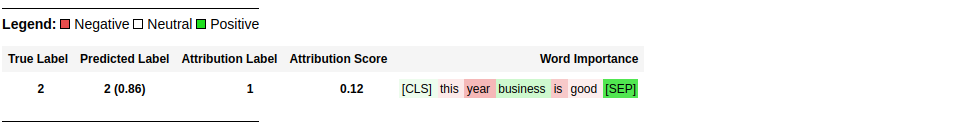

In [77]:
import IPython.display
IPython.display.Image(filename="AGNews_Captum_Insights.png")
